In [ ]:
%load_ext autoreload
%autoreload 2 
%pylab inline
import os
from pathlib import Path

import haiku as hk
os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/gpfslocalsys/cuda/10.1.2'
import jax
from jax.experimental import optix
import jax.numpy as jnp
from nsec.normalization import SNParamsTree as CustomSNParamsTree
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
import tensorflow_datasets as tfds
from tqdm.notebook import tqdm

os.environ['SINGLECOIL_TRAIN_DIR'] = 'singlecoil_train/singlecoil_train/'
from tf_fastmri_data.datasets.noisy import NoisyFastMRIDatasetBuilder
from nsec.models.dae.convdae import SmallUResNet
from nsec.samplers import ScoreHamiltonianMonteCarlo, ScoreMetropolisAdjustedLangevinAlgorithm

Populating the interactive namespace from numpy and matplotlib


In [ ]:
batch_size = 32

train_mri_ds = NoisyFastMRIDatasetBuilder(
    dataset='train',
    brain=False,
    scale_factor=1e6,
    noise_power_spec=30,
    noise_input=True,
    noise_mode='gaussian',
    residual_learning=True,
    batch_size=batch_size,
    slice_random=True,
)
n_steps = int(1e3)
mri_images_iterator = train_mri_ds.preprocessed_ds.take(n_steps).as_numpy_iterator()

val_mri_ds = NoisyFastMRIDatasetBuilder(
    dataset='val',
    brain=False,
    scale_factor=1e6,
    noise_power_spec=30,
    noise_input=True,
    noise_mode='gaussian',
    residual_learning=True,
    batch_size=batch_size,
    slice_random=True,
)
val_mri_images_iterator = val_mri_ds.preprocessed_ds.as_numpy_iterator()

##### BATCH DEFINITION
# (image_noisy, noise_power), noise_realisation
# here the noise_realisation is the full one, not the epsilon from the standard normal law

In [ ]:
def forward(x, s, is_training=False):
    denoiser = SmallUResNet()
    return denoiser(x, s, is_training=is_training)

model = hk.transform_with_state(forward)

sn_fn = hk.transform_with_state(lambda x: CustomSNParamsTree(ignore_regex='[^?!.]*b$',val=2.)(x))

In [ ]:
optimizer = optix.adam(1e-4)
rng_seq = hk.PRNGSequence(42)

In [ ]:
params, state = model.init(next(rng_seq), jnp.zeros((1, 32, 32, 1)), jnp.zeros((1, 1, 1, 1)), is_training=True)
opt_state = optimizer.init(params)

_, sn_state = sn_fn.init(jax.random.PRNGKey(1), params)

In [ ]:
@jax.jit
def loss_fn(params, state, rng_key, batch):
    (x, s), su = batch
    # this to stick to the original shape of the noise power
    s = s[..., None, None, None]
    res, state = model.apply(params, state, rng_key, x, s, is_training=True)
    loss = jnp.mean((su / s + s * res)**2)
    return loss, state

In [ ]:
@jax.jit
def update(params, state, sn_state, rng_key, opt_state, batch):
    (loss, state), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, state, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    
    new_params = optix.apply_updates(params, updates)
    
    new_params, new_sn_state = sn_fn.apply(None, sn_state, None, new_params)
    
    return loss, new_params, state, new_sn_state, new_opt_state

In [ ]:
losses = []

In [ ]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

In [ ]:
for step, batch in tqdm(enumerate(mri_images_iterator), total=n_steps):
    loss, params, state, sn_state, opt_state = update(params, state, sn_state, next(rng_seq), opt_state, batch)
    losses.append(loss)
    if step%100==0:
        print(step, loss)

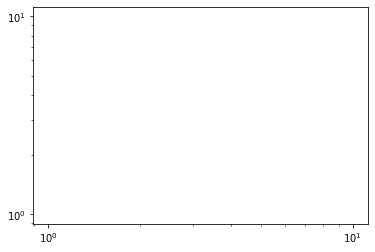

In [27]:
loglog(losses[10:])

In [ ]:
# Saving params
import pickle

# with open('conv-dae-L2.pckl', 'wb') as file:
#     pickle.dump([params, state, sn_state], file)

In [15]:
# Importing saved model
with open('conv-dae-L2.pckl', 'rb') as file:
    params, state, sn_state = pickle.load(file)

FileNotFoundError: [Errno 2] No such file or directory: 'conv-dae-L2.pckl'

In [28]:
from functools import partial
score = partial(model.apply, params, state, next(rng_seq))

In [37]:
(x, s), su = next(val_mri_images_iterator)
s = s[..., None, None, None]
res, state = score(x, s, is_training=False)

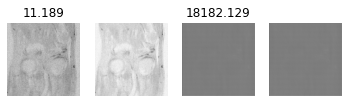

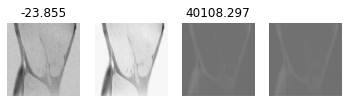

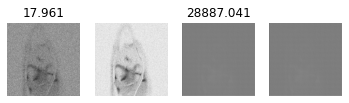

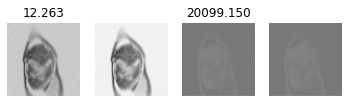

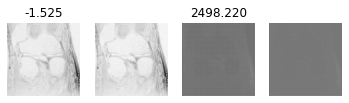

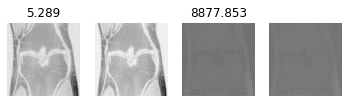

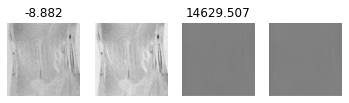

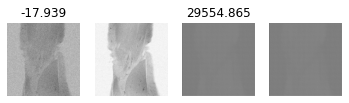

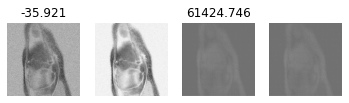

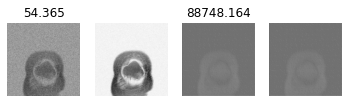

In [38]:
for i in range(10):
  ind = i
  figure()
  subplot(141)
  title("%0.3f"%s[ind,0,0,0])
  imshow(x[ind,...,0],cmap='gray_r')
  axis('off')
  subplot(142)
  imshow((x - su)[ind,...,0],cmap='gray_r')
  axis('off')
  subplot(143)
  imshow(res[ind,...,0],cmap='gray_r')
  axis('off')
  title("%0.3f"%std(s[ind,:,:,0]**2 *res[ind,...,0]))
  subplot(144)
  imshow(x[ind,...,0] + s[ind,:,:,0]**2 * res[ind,...,0],cmap='gray_r')
  axis('off')

In [39]:
# Trying to sample from the model

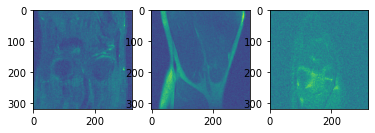

In [40]:
subplot(131)
imshow(x[0,...,0].reshape((320,320,)))
subplot(132)
imshow(x[1,...,0].reshape((320,320,)))
subplot(133)
imshow(x[2,...,0].reshape((320,320,)))

In [41]:
def score_fn(x):
    return score(x.reshape((1,320,320,1)), jnp.zeros((1,1,1,1))+1e-2, is_training=False)[0].reshape((320*320,))

In [42]:
score_fn(x[0,...,0])

DeviceArray([  11528.097, -155299.56 ,   71010.93 , ..., -271816.66 ,
             -152608.52 , -184365.36 ], dtype=float32)

In [22]:
num_results = int(1e4)
num_burnin_steps = int(1e1)

In [30]:
@jax.jit
def get_samples():
    # First running SHMC
    kernel_shmc = ScoreHamiltonianMonteCarlo(
            target_score_fn=score_fn,
            num_leapfrog_steps=4,
            num_delta_logp_steps=4,
            step_size=0.01,
    )
 
    samples_shmc, is_accepted_shmc = tfp.mcmc.sample_chain(
          num_results=num_results,
          num_burnin_steps=num_burnin_steps,
          current_state= batch['x'][0,...,0].reshape((32*32,)),#0.5*randn(32,32).reshape((32*32,)).astype('float32'),#
          kernel=kernel_shmc,
          trace_fn=lambda _, pkr: pkr.is_accepted, 
#           seed=jax.random.PRNGKey(1),
    )
    return samples_shmc, is_accepted_shmc 
 
samples_shmc, is_accepted_shmc = get_samples()

ValueError: Must provide a PRNGKey for JAX SeedStream.

In [ ]:
%debug

> /linkhome/rech/gencea10/uap69lx/.local/lib/python3.7/site-packages/jax/lax/lax.py(81)broadcast_shapes()
     79   if result_shape is None:
     80     raise ValueError("Incompatible shapes for broadcasting: {}"
---> 81                      .format(tuple(map(tuple, shapes))))
     82   return result_shape
     83 

ipdb> u
> /linkhome/rech/gencea10/uap69lx/.local/lib/python3.7/site-packages/jax/numpy/lax_numpy.py(242)_promote_shapes()
    240       if FLAGS.jax_numpy_rank_promotion != "allow":
    241         _rank_promotion_warning_or_error(fun_name, shapes)
--> 242       result_rank = len(lax.broadcast_shapes(*shapes))
    243       return [broadcast_to(arg, (1,) * (result_rank - len(shp)) + shp)
    244               for arg, shp in zip(args, shapes)]

ipdb> u
> /linkhome/rech/gencea10/uap69lx/.local/lib/python3.7/site-packages/jax/numpy/lax_numpy.py(303)_promote_args()
    301   """Convenience function to apply Numpy argument shape and dtype promotion."""
    302   _check_arraylik

In [ ]:
len(where(is_accepted_shmc)[0])

In [ ]:
samples_shmc = samples_shmc[where(is_accepted_shmc)[0]]

In [ ]:
figure(figsize=(20,20))
for i in range(10):
  for j in range(10):
    subplot(10,10,10*i+j+1)
    imshow(samples_shmc[(10*i+j)].reshape((32,32)))
    axis('off')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [ ]:
fig2 = plt.figure()

ims = []
for i in inds[::5]:
    ims.append((plt.imshow(samples_shmc[i].reshape((32,32))),))

In [ ]:
im_ani = animation.ArtistAnimation(fig2, ims, interval-5, repeat_delay=3000,
                                   blit=True)

In [ ]:
im_ani.save('im2.mp4', metadata={'artist':'Guido'},codec="libx264" )

In [ ]:
figure(figsize=(20,20))
for i in range(10):
  for j in range(10):
    subplot(10,10,10*i+j+1)
    imshow(samples_shmc[(10*i+j)*100].reshape((32,32)))
    axis('off')

In [ ]:
figure(figsize=(20,20))
for i in range(10):
  for j in range(10):
    subplot(10,10,10*i+j+1)
    imshow(samples_shmc[(10*i+j)*1000].reshape((32,32)))
    axis('off')

In [ ]:
figure(figsize=(20,20))
for i in range(10):
  for j in range(10):
    subplot(10,10,10*i+j+1)
    imshow(samples_shmc[(10*i+j)*1000].reshape((32,32)))
    axis('off')

In [ ]:
figure(figsize=(20,20))
for i in range(10):
  for j in range(10):
    subplot(10,10,10*i+j+1)
    imshow(samples_shmc[(10*i+j)*100].reshape((32,32)))
    axis('off')

In [ ]:
figure(figsize=(20,20))
for i in range(10):
  for j in range(10):
    subplot(10,10,10*i+j+1)
    imshow(samples_shmc[(10*i+j)*100].reshape((32,32)))
    axis('off')

In [ ]:
len(where(is_accepted_shmc)[0])

In [ ]:
figure(figsize=(20,20))
for i in range(10):
  for j in range(10):
    subplot(10,10,10*i+j+1)
    imshow(samples_shmc[(10*i+j)*250].reshape((32,32)))
    axis('off')

In [ ]:
imshow(samples_shmc[-1].reshape((32,32))); colorbar()

In [ ]:
figure(figsize=(20,20))
for i in range(10):
  for j in range(10):
    subplot(10,10,10*i+j+1)
    imshow(samples_shmc[(10*i+j)*10].reshape((32,32)))
    axis('off')